In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import importlib

from config import *
from utils.load_data import load_distributional_dataset
from models.gaussian_forward import GaussianForwardModel

# === setup device ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# === choose trial number to revisit ===
trial = 9  # change this to revisit old checkpoints
is_old_trial = trial < TRIAL_GAUSSIAN

# === define dimensions for old trials ===
s_dim_old = 4
p_dim_old = 9
hidden_dims_old = [64]
model_path_old = f"checkpoints/gaussian/gaussian_ckpt_{trial}.pt"

# === dynamically configure model ===
if is_old_trial:
    s_dim = s_dim_old
    p_dim = p_dim_old
    hidden_dims = hidden_dims_old
    model_path = model_path_old
else:
    s_dim = S_DIM
    p_dim = P_DIM
    hidden_dims = HIDDEN_DIMS
    model_path = GAUSSIAN_SAVE_PATH

# === load model ===
model = GaussianForwardModel(s_dim, p_dim, hidden_dims=hidden_dims).to(device)
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()

# === print model architecture ===
print("\n✅ Gaussian Forward Model Loaded:\n", model)

# === load dataset ===
P_all, S_all = load_dataset(DATA_PATH)
S_val = S_all[0].unsqueeze(0).to(device)  # shape: (1, 4)
P_true = P_all[0].cpu().numpy()           # shape: (9,)



✅ Gaussian Forward Model Loaded:
 GaussianForwardModel(
  (backbone): Sequential(
    (0): Linear(in_features=4, out_features=64, bias=True)
    (1): Tanh()
  )
  (mu): Linear(in_features=64, out_features=9, bias=True)
  (log_sigma): Linear(in_features=64, out_features=9, bias=True)
)


/var/folders/9z/9fdpt4_148s8zzl9h0tr9dgw0000gn/T/ipykernel_98418/2772754872.py:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path,

In [ ]:
# === prediction and sampling function ===
def get_P_predictions(S_val, num_samples=800):
    """
    Returns the predicted Gaussian (µ, σ) and samples P ~ N(µ, σ²)
    """
    S_tensor = S_val.repeat(num_samples, 1).to(device)  # shape: (N, 4)

    with torch.no_grad():
        mu, log_sigma = model(S_tensor)
        sigma = torch.exp(log_sigma)
        eps = torch.randn_like(mu)
        P_samples = mu + sigma * eps

    return mu[0].cpu().numpy(), sigma[0].cpu().numpy(), P_samples.cpu().numpy()

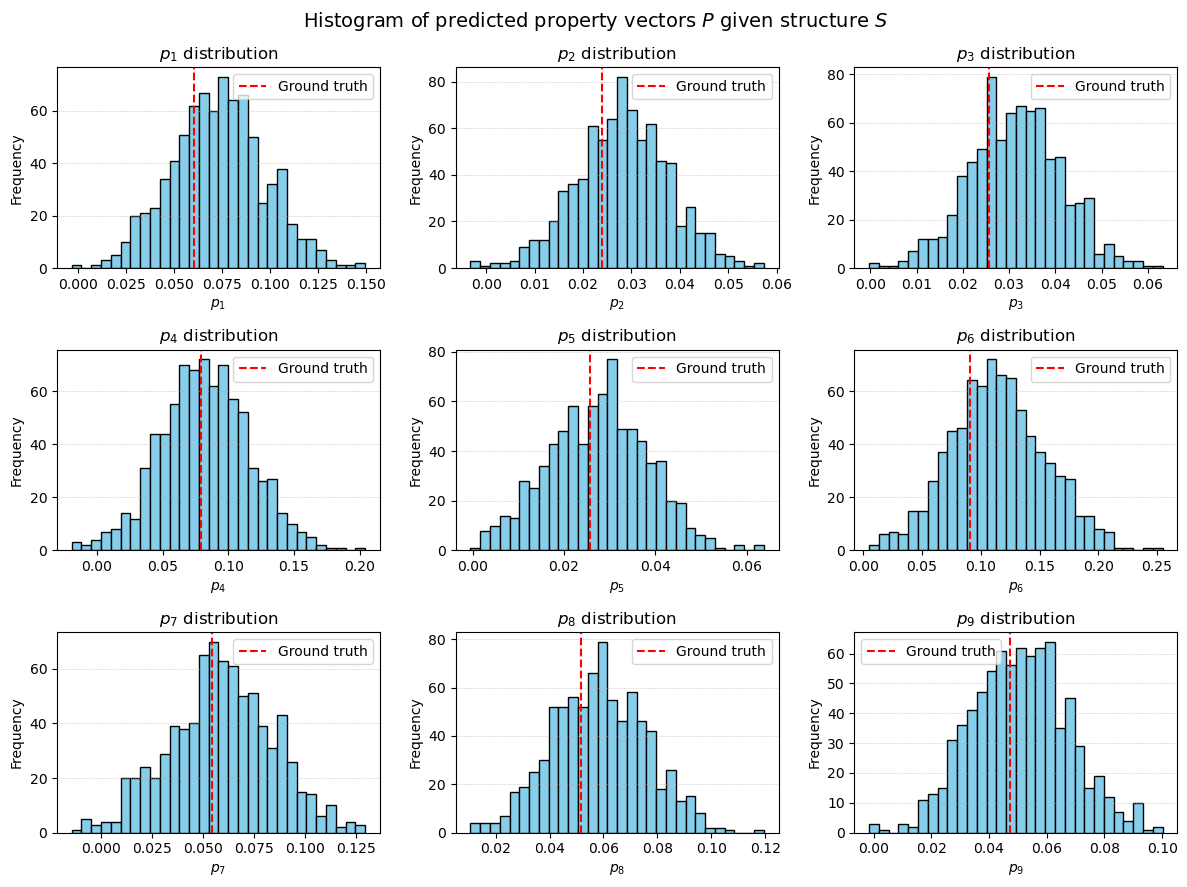

In [ ]:
# === sample P_hat values ===
mu_pred, sigma_pred, P_hats = get_P_predictions(S_val, num_samples=800)

# === plot histograms with ground-truth lines ===
fig, axs = plt.subplots(3, 3, figsize=(12, 9))  # 3 rows, 3 columns
axs = axs.flatten()

for i in range(9):
    axs[i].hist(P_hats[:, i], bins=30, color='skyblue', edgecolor='black')
    axs[i].axvline(P_true[i], color='red', linestyle='--', label='Ground truth')
    axs[i].set_title(f"$p_{i+1}$ distribution")
    axs[i].set_xlabel(f"$p_{i+1}$")
    axs[i].set_ylabel("Frequency")
    axs[i].legend()
    axs[i].grid(True, axis='y', linestyle=':', linewidth=0.5)

fig.suptitle("Histogram of predicted property vectors $P$ given structure $S$", fontsize=14)
plt.tight_layout()
plt.show()

In [ ]:
from tabulate import tabulate
import numpy as np
from scipy.stats import percentileofscore

def evaluate_gaussian_predictions(P_hats, P_true):
    """
    Evaluate predicted P samples vs. ground truth using statistical metrics.
    """
    rows = []
    norm_deltas = []

    for i in range(9):
        p_pred = P_hats[:, i]
        p_true = P_true[i]

        # stats
        perc_rank = percentileofscore(p_pred, p_true)
        spread = np.std(p_pred)

        # mode–truth distance
        hist, bins = np.histogram(p_pred, bins=30)
        bin_centers = (bins[:-1] + bins[1:]) / 2
        mode = bin_centers[np.argmax(hist)]
        mode_dist = abs(mode - p_true)
        norm_dist = mode_dist / spread if spread > 0 else float('inf')

        rows.append([
            f"p{i+1}",
            f"{perc_rank:.1f}%",
            f"{spread:.4f}",
            f"{mode_dist:.4f}",
            f"{norm_dist:.2f}"
        ])

        norm_deltas.append(norm_dist)

    headers = ["p_i", "%ile", "σ", "Δ", "Δ / σ"]
    print(tabulate(rows, headers=headers, tablefmt="fancy_grid"))

    avg_norm_delta = np.mean(norm_deltas)
    print(f"\n Average normalized mode distance (Δ / σ): {avg_norm_delta:.2f}")

evaluate_gaussian_predictions(P_hats, P_true)


╒═══════╤════════╤════════╤════════╤═════════╕
│ p_i   │ %ile   │      σ │      Δ │   Δ / σ │
╞═══════╪════════╪════════╪════════╪═════════╡
│ p1    │ 30.2%  │ 0.024  │ 0.0153 │    0.64 │
├───────┼────────┼────────┼────────┼─────────┤
│ p2    │ 32.2%  │ 0.0096 │ 0.0041 │    0.43 │
├───────┼────────┼────────┼────────┼─────────┤
│ p3    │ 28.6%  │ 0.0099 │ 0.0004 │    0.04 │
├───────┼────────┼────────┼────────┼─────────┤
│ p4    │ 47.2%  │ 0.0339 │ 0.0018 │    0.05 │
├───────┼────────┼────────┼────────┼─────────┤
│ p5    │ 42.8%  │ 0.0108 │ 0.0048 │    0.44 │
├───────┼────────┼────────┼────────┼─────────┤
│ p6    │ 28.1%  │ 0.0405 │ 0.0183 │    0.45 │
├───────┼────────┼────────┼────────┼─────────┤
│ p7    │ 42.9%  │ 0.0254 │ 0.0005 │    0.02 │
├───────┼────────┼────────┼────────┼─────────┤
│ p8    │ 35.4%  │ 0.0174 │ 0.0078 │    0.45 │
├───────┼────────┼────────┼────────┼─────────┤
│ p9    │ 42.4%  │ 0.0168 │ 0.014  │    0.83 │
╘═══════╧════════╧════════╧════════╧═════════╛

 Average nor